In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import time

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

batch_size = 100
num_epochs = 5

In [2]:
transform = transforms.Compose(
    (transforms.ToTensor(),
     transforms.Normalize((0.5,), (1,))
     ))

train_dataset = torchvision.datasets.MNIST(root='../_data',
                                           train=True,
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../_data',
                                          train=False,
                                          transform=transform)

train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False)

mnist_training_data = {}
mnist_test_data = {}

print('Loading data')

for i, (images, labels) in enumerate(train_loader):
    mnist_training_data[i] = (images, labels)
    
for i, (images, labels) in enumerate(test_loader):
    mnist_test_data[i] = (images, labels)
    
print('Load data ok')

Loading data
Load data ok


In [3]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    @staticmethod
    def name():
        return 'MLPNet'

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x, 2, 2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    @staticmethod
    def name():
        return 'LeNet'

In [4]:
net = LeNet().cuda()
# try:
#     net.load_state_dict(torch.load(f'{net.name()}.ckpt'))
# except RuntimeError:
#     pass
# except FileNotFoundError:
#     pass


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)


In [5]:
def test_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for _images, _labels in test_loader:
            _images = _images.cuda()
            _labels = _labels.cuda()
            _outputs = net(_images)
            total_loss += criterion(outputs, labels)
            _, predicted = torch.max(_outputs.data, 1)
            total += _labels.size(0)
            correct += (predicted == _labels).sum().item()
    print(f'test loss      = {total_loss / len(mnist_test_data):.5}')
    print(f'test accuracy  = {correct / total * 100:.4}%\n')


In [6]:
time_start = time.time()
for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in mnist_training_data.items():
        # Move tensors to the configured device
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = f.softmax(net(images), dim=1)
        loss = criterion(outputs, labels)
        total_loss += loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\r' + f'epoch={epoch + 1}, batch={i + 1}, time={(time.time()-time_start):.5} secs', end='')
    print(f'\ntrain loss     = {total_loss / len(mnist_training_data):.5}')
    test_accuracy()

# torch.save(net.state_dict, f'{net.name()}.ckpt')


epoch=1, batch=600, time=9.092 secss
train loss     = 2.0971
test loss      = 1.613
test accuracy  = 89.14%

epoch=2, batch=600, time=18.025 secs
train loss     = 1.5468
test loss      = 1.515
test accuracy  = 95.22%

epoch=3, batch=600, time=27.322 secs
train loss     = 1.5093
test loss      = 1.5109
test accuracy  = 96.89%

epoch=4, batch=600, time=36.804 secs
train loss     = 1.4969
test loss      = 1.5039
test accuracy  = 97.41%

epoch=5, batch=600, time=45.471 secs
train loss     = 1.4906
test loss      = 1.4953
test accuracy  = 97.7%



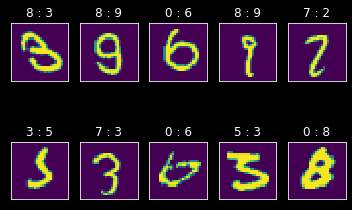

In [7]:
def show_wrong_guess():
    wrong_guess_cnt = 0
    for _, (_images, _labels) in mnist_test_data.items():
        _images = _images.cuda()
        _labels = _labels.cuda()
        _outputs = net(_images)
        _, predicted = torch.max(_outputs, 1)
        wrong = (predicted != _labels)
        for j in range(batch_size):
            if wrong[j]:
                if wrong_guess_cnt == 10:
                    break
                plt.subplot(2, 5, wrong_guess_cnt + 1)
                plt.imshow(_images[j][0].cpu())
                plt.xticks([])
                plt.yticks([])
                plt.title(f'{predicted[j]} : {_labels[j]}')
                wrong_guess_cnt += 1
        if wrong_guess_cnt == 10:
            break
            
show_wrong_guess()

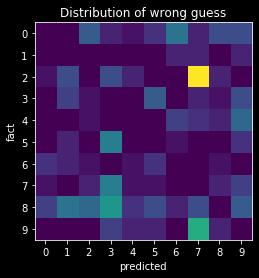

In [8]:
def show_contingency_grid():
    grayscale = np.zeros((10, 10))
    for _, (_images, _labels) in mnist_test_data.items():
        _images = _images.cuda()
        _labels = _labels.cuda()
        _outputs = net(_images)
        _, predicted = torch.max(_outputs, 1)
        for j in range(batch_size):
            if predicted[j] != _labels[j]:
                grayscale[predicted[j]][_labels[j]] += 1
    plt.imshow(grayscale)
    plt.xticks(np.linspace(0, 9, num=10))
    plt.xlabel('predicted')
    plt.yticks(np.linspace(0, 9, num=10))
    plt.ylabel('fact')
    plt.title('Distribution of wrong guess')

show_contingency_grid()
            

In [9]:
# t1 = torch.randn(1, 3)
# t2 = torch.tensor([1])
# print(t1, t2, sep='\n')
# criterion(t1, t2)


